# Uso de filtros espaciales y morfológicos

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_unir_color = cv.imread('im/unir-1.jpg')
image_unir_grays = cv.imread('im/unir-1.jpg', cv.IMREAD_GRAYSCALE)

In [3]:
def mask(n):
    '''Define a nxn mask.
    Useful for a quick filter
    '''
    mask = np.ones((n,n), np.uint8)
    return mask

kernel_3 = mask(3)
kernel_5 = mask(5)

In [4]:
im = image_unir_grays

erosion = cv.erode(im, kernel_5, iterations=1)
dilation = cv.dilate(im, kernel_5, iterations=1)
cv.imwrite('out/erosion.jpg', erosion)
cv.imwrite('out/dilation.jpg', dilation)

True

In [5]:
border_d_e = cv.subtract(dilation, erosion)
border_i_e = cv.subtract(im, erosion)
border_res = dilation - erosion
cv.imwrite('out/border_d_e.jpg', border_d_e)
cv.imwrite('out/border_i_e.jpg', border_i_e)
cv.imwrite('out/border_res.jpg', border_res)

True

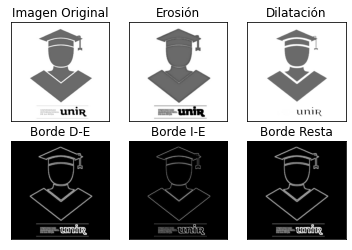

In [6]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
erosion = cv.cvtColor(erosion, cv.COLOR_BGR2RGB)
dilation = cv.cvtColor(dilation, cv.COLOR_BGR2RGB)
border_d_e = cv.cvtColor(border_d_e, cv.COLOR_BGR2RGB)
border_i_e = cv.cvtColor(border_i_e, cv.COLOR_BGR2RGB)
border_res = cv.cvtColor(border_res, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(erosion)
plt.title('Erosión'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(dilation)
plt.title('Dilatación'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(border_d_e)
plt.title('Borde D-E'), plt.xticks([]), plt.yticks([])
plt.subplot(235)
plt.imshow(border_i_e)
plt.title('Borde I-E'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(border_res)
plt.title('Borde Resta'), plt.xticks([]), plt.yticks([])
plt.show()